In [33]:
import numpy as np

import itertools
import warnings

import matplotlib.pyplot as plt
import networkx as nx

warnings.filterwarnings("ignore", category=FutureWarning)

B matrix:
 [[1 1 0 0 0 0]
 [1 0 0 0 1 0]
 [0 1 1 0 0 0]
 [0 0 1 1 0 0]
 [0 0 0 1 0 1]
 [0 0 0 0 1 1]]


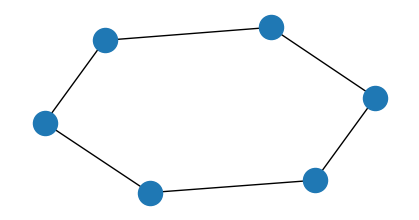

In [306]:
NUM_NODES = 6
GRAPH_DEGREE = 2

G = nx.random_regular_graph(d=GRAPH_DEGREE, n=NUM_NODES, seed=1)

B =  np.array([[1, 1, 0, 0, 0, 0], # from classiq
                [1, 0, 0, 0, 1, 0],
                [0, 1, 1, 0, 0, 0],
                [0, 0, 1, 1, 0, 0],
                [0, 0, 0, 1, 0, 1],
                [0, 0, 0, 0, 1, 1]])
# B = nx.incidence_matrix(G).T.toarray().astype(int)
v = np.ones(B.shape[0], dtype=int)

plt.figure(figsize=(4, 2))
nx.draw(G)
print("B matrix:\n", B)

In [307]:
from initialization.calculate_w import calculate_w
from initialization.construct_A import construct_A_matrix

In [308]:
import numpy as np
from itertools import product

def brute_force_max(B, v, top_n=10):
    num_vars = B.shape[1]  # Number of variables in x
    results = []
    
    # Iterate over all possible binary values of x
    for x_tuple in product([0, 1], repeat=num_vars):
        x = np.array([x_tuple])  # Convert tuple to numpy array
        value = len(B) - sum((B @ x.T + v) % 2)[0]
        results.append((x, value))
    
    # Sort by value in descending order
    results.sort(key=lambda pair: pair[1], reverse=True)
    
    # Get the top N results
    top_results = results[:top_n]
    
    return top_results

top_results = brute_force_max(B, v, top_n=10)
print("Top results:")
for x, value in top_results:
    print("x:", x, "Value:", value)


Top results:
x: [[0 1 0 1 1 0]] Value: 6
x: [[1 0 1 0 0 1]] Value: 6
x: [[0 0 0 1 1 0]] Value: 4
x: [[0 0 1 0 0 1]] Value: 4
x: [[0 0 1 0 1 0]] Value: 4
x: [[0 0 1 0 1 1]] Value: 4
x: [[0 0 1 1 1 0]] Value: 4
x: [[0 1 0 0 0 1]] Value: 4
x: [[0 1 0 0 1 0]] Value: 4
x: [[0 1 0 0 1 1]] Value: 4


In [352]:
n = len(B[0])
m, p, r, ell = len(B), 2, 1, 3

# Sparse matrix
A, _ = construct_A_matrix(m, ell, p, r)
w, _ = calculate_w(A)
w

array([-0.26531999, -0.54304818, -0.65544283, -0.45287821])

In [353]:
m

6

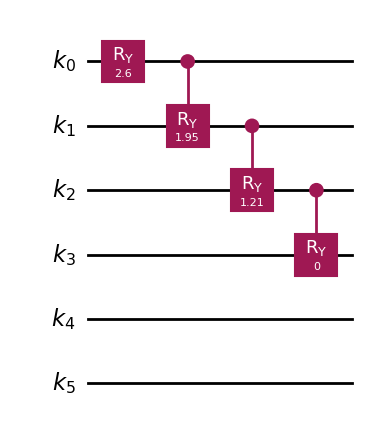

In [354]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from initialization.state_preparation.gates import WeightedUnaryEncoding

init_qregs = QuantumRegister(m, name='k')
initialize_circuit = QuantumCircuit(init_qregs)
WUE_Gate = WeightedUnaryEncoding(m, w)
initialize_circuit.append(WUE_Gate, range(m))
display(initialize_circuit.decompose().draw('mpl'))


In [355]:
Statevector(initialize_circuit).draw('latex')

<IPython.core.display.Latex object>

In [356]:
from dicke_state_preparation.gates import UnkStatePreparation
from utils import binary_combinations

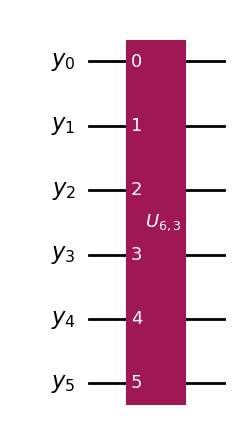

In [357]:
from qiskit.circuit.library import DraperQFTAdder

dicke_qregs = QuantumRegister(m, name='y') 

dicke_circuit = QuantumCircuit(dicke_qregs)
ctrl_states = binary_combinations(ell-1)
dicke_circuit.append(UnkStatePreparation(m, 2**(ell-1)-1).to_gate(), range(m))
dicke_circuit.draw('mpl')

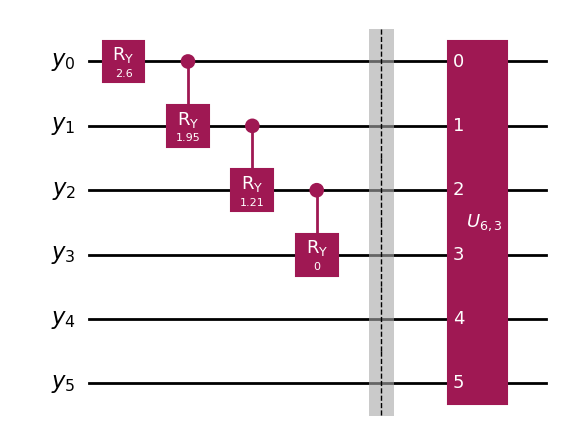

In [358]:
from qiskit.circuit.library import FullAdderGate

combine_circuit_1 = QuantumCircuit(dicke_qregs)
combine_circuit_1.compose(initialize_circuit, inplace=True)
combine_circuit_1.barrier()
# combine_circuit_1.append(FullAdderGate(1), range(3, -1, -1))
combine_circuit_1.compose(dicke_circuit, inplace=True)
combine_circuit_1.decompose().draw('mpl')

In [359]:
from qiskit.quantum_info import Statevector
Statevector(combine_circuit_1.decompose()).draw('latex')

<IPython.core.display.Latex object>

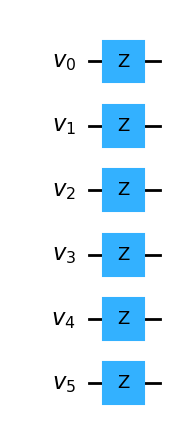

In [360]:
v_phase_qregs = QuantumRegister(m, name='v')
v_phase_flip_circuit = QuantumCircuit(v_phase_qregs)
for i in range(len(v)):
    if v[i] == 1:
        v_phase_flip_circuit.z(i)
v_phase_flip_circuit.draw('mpl')

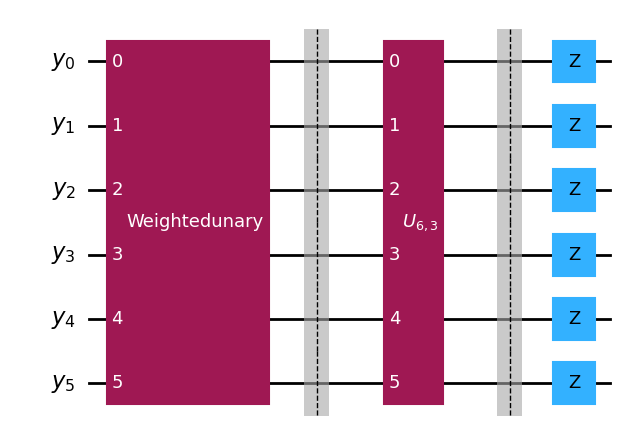

In [361]:
combine_circuit_2 = QuantumCircuit(dicke_qregs)
combine_circuit_2.compose(initialize_circuit, inplace=True)
combine_circuit_2.barrier()
combine_circuit_2.compose(dicke_circuit, inplace=True)
combine_circuit_2.barrier()
combine_circuit_2.compose(v_phase_flip_circuit, qubits=range(m), inplace=True)
combine_circuit_2.draw('mpl')

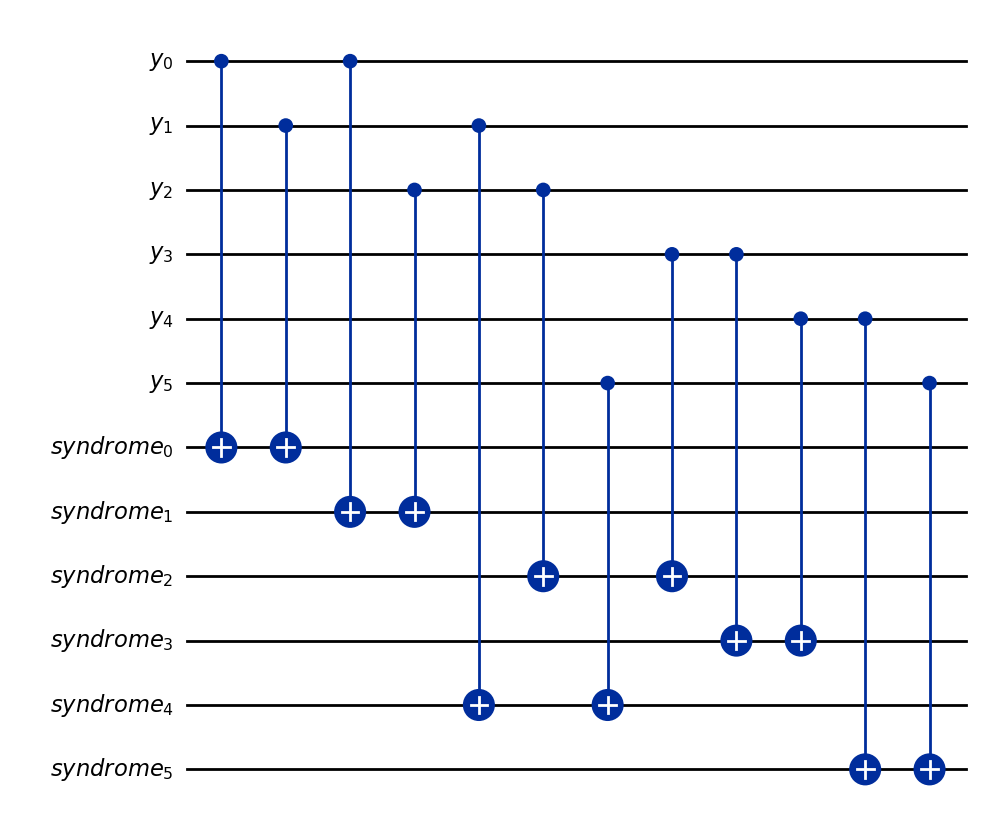

In [362]:
syndrome_qregs = QuantumRegister(n, name='syndrome')
B_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs)
for i in range(n):
    for j in range(m):
        if B.T[i][j] == 1:
            B_circuit.cx(j, m+i)
            
B_circuit.draw('mpl')

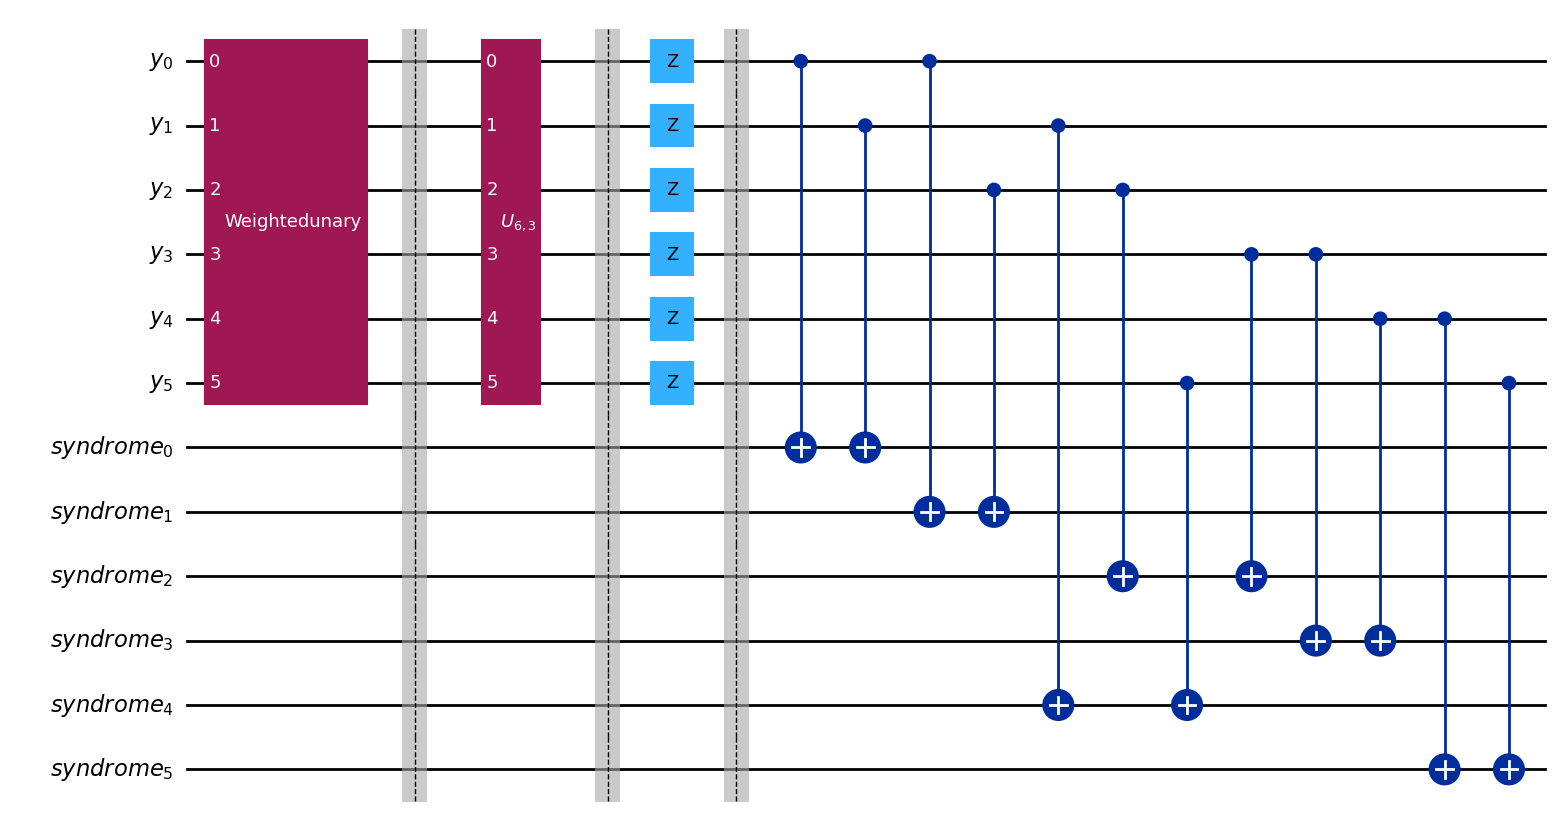

In [363]:
combine_circuit_3 = QuantumCircuit(dicke_qregs, syndrome_qregs)
combine_circuit_3.compose(initialize_circuit, inplace=True)
combine_circuit_3.barrier()
combine_circuit_3.compose(dicke_circuit, inplace=True)
combine_circuit_3.barrier()
combine_circuit_3.compose(v_phase_flip_circuit, qubits=range(m), inplace=True)
combine_circuit_3.barrier()
combine_circuit_3.compose(B_circuit, qubits=list(range(m+n)), inplace=True)
combine_circuit_3.draw('mpl')

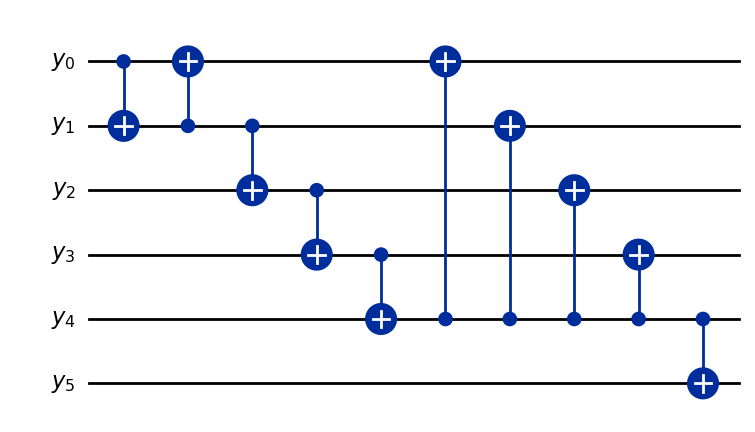

In [364]:
from decoding.gates import GJEGate
decoding_circuit = QuantumCircuit(dicke_qregs)
GJE_gate = GJEGate(B)
decoding_circuit.append(GJE_gate, range(m))
decoding_circuit.decompose().draw('mpl')

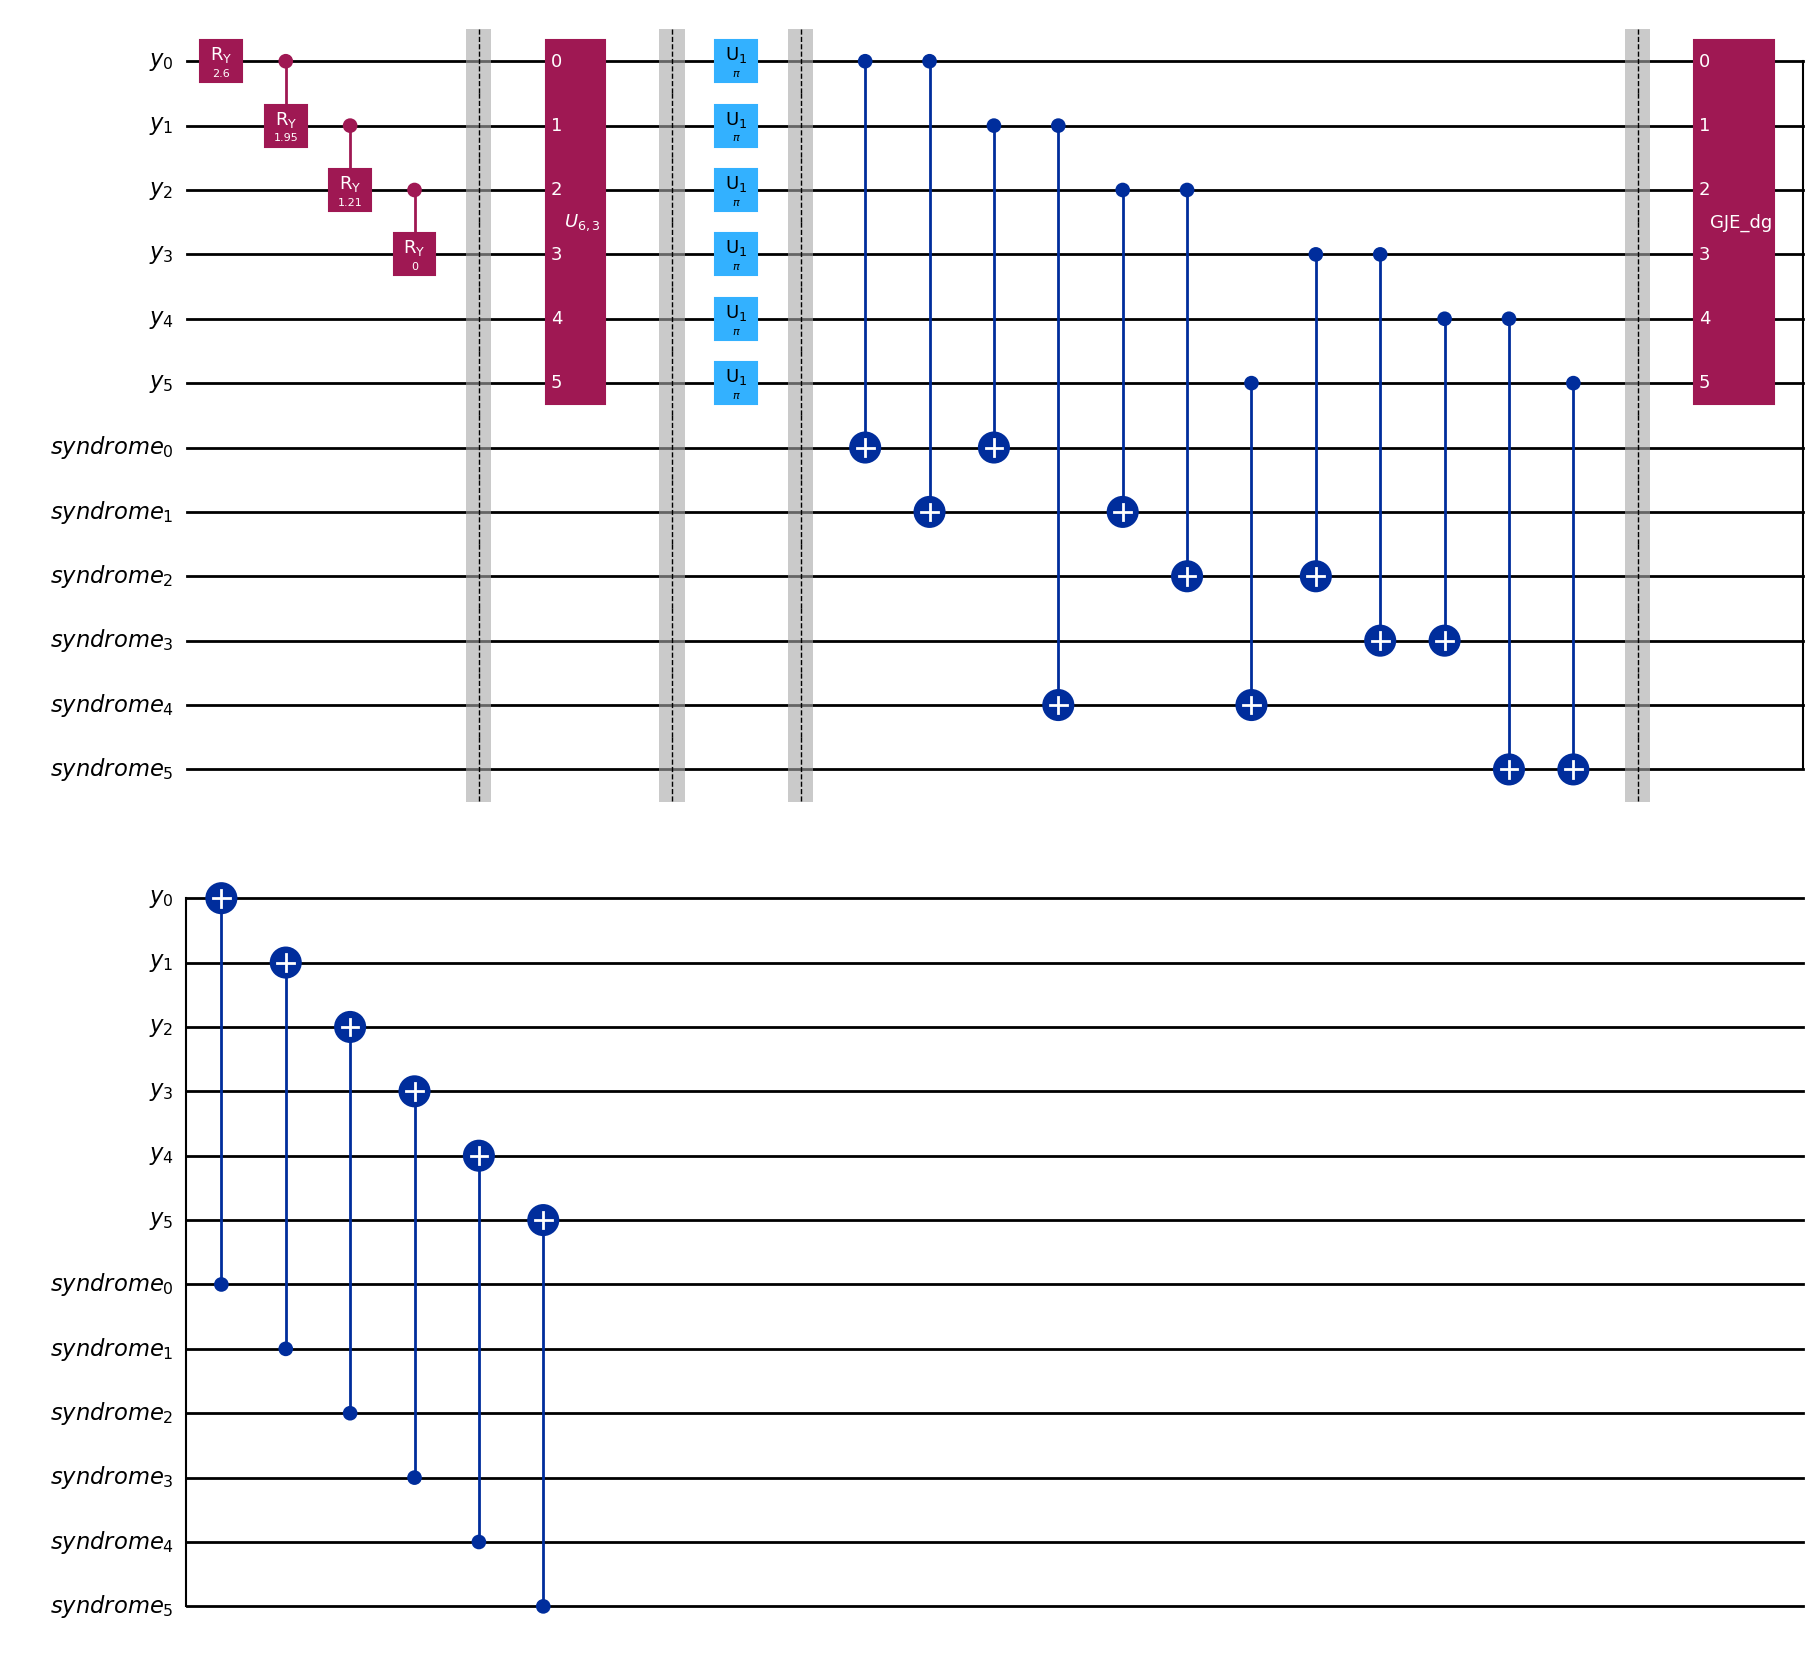

In [365]:
combine_circuit_4 = QuantumCircuit(dicke_qregs, syndrome_qregs)
combine_circuit_4.compose(initialize_circuit, inplace=True)
combine_circuit_4.barrier()
combine_circuit_4.compose(dicke_circuit, inplace=True)
combine_circuit_4.barrier()
combine_circuit_4.compose(v_phase_flip_circuit, qubits=range(m), inplace=True)
combine_circuit_4.barrier()
combine_circuit_4.compose(B_circuit, qubits=list(range(m+n)), inplace=True)
combine_circuit_4.barrier()
combine_circuit_4.append(decoding_circuit.inverse(), range(m))
for i in range(dicke_qregs.size):
    combine_circuit_4.cx(syndrome_qregs[i], dicke_qregs[i])


combine_circuit_4.decompose().draw('mpl')

In [366]:
from qiskit.quantum_info import partial_trace
reduced_density_matrix = partial_trace(Statevector(combine_circuit_4), range(dicke_qregs.size))

Statevector(np.diagonal(reduced_density_matrix)).draw('latex')


<IPython.core.display.Latex object>

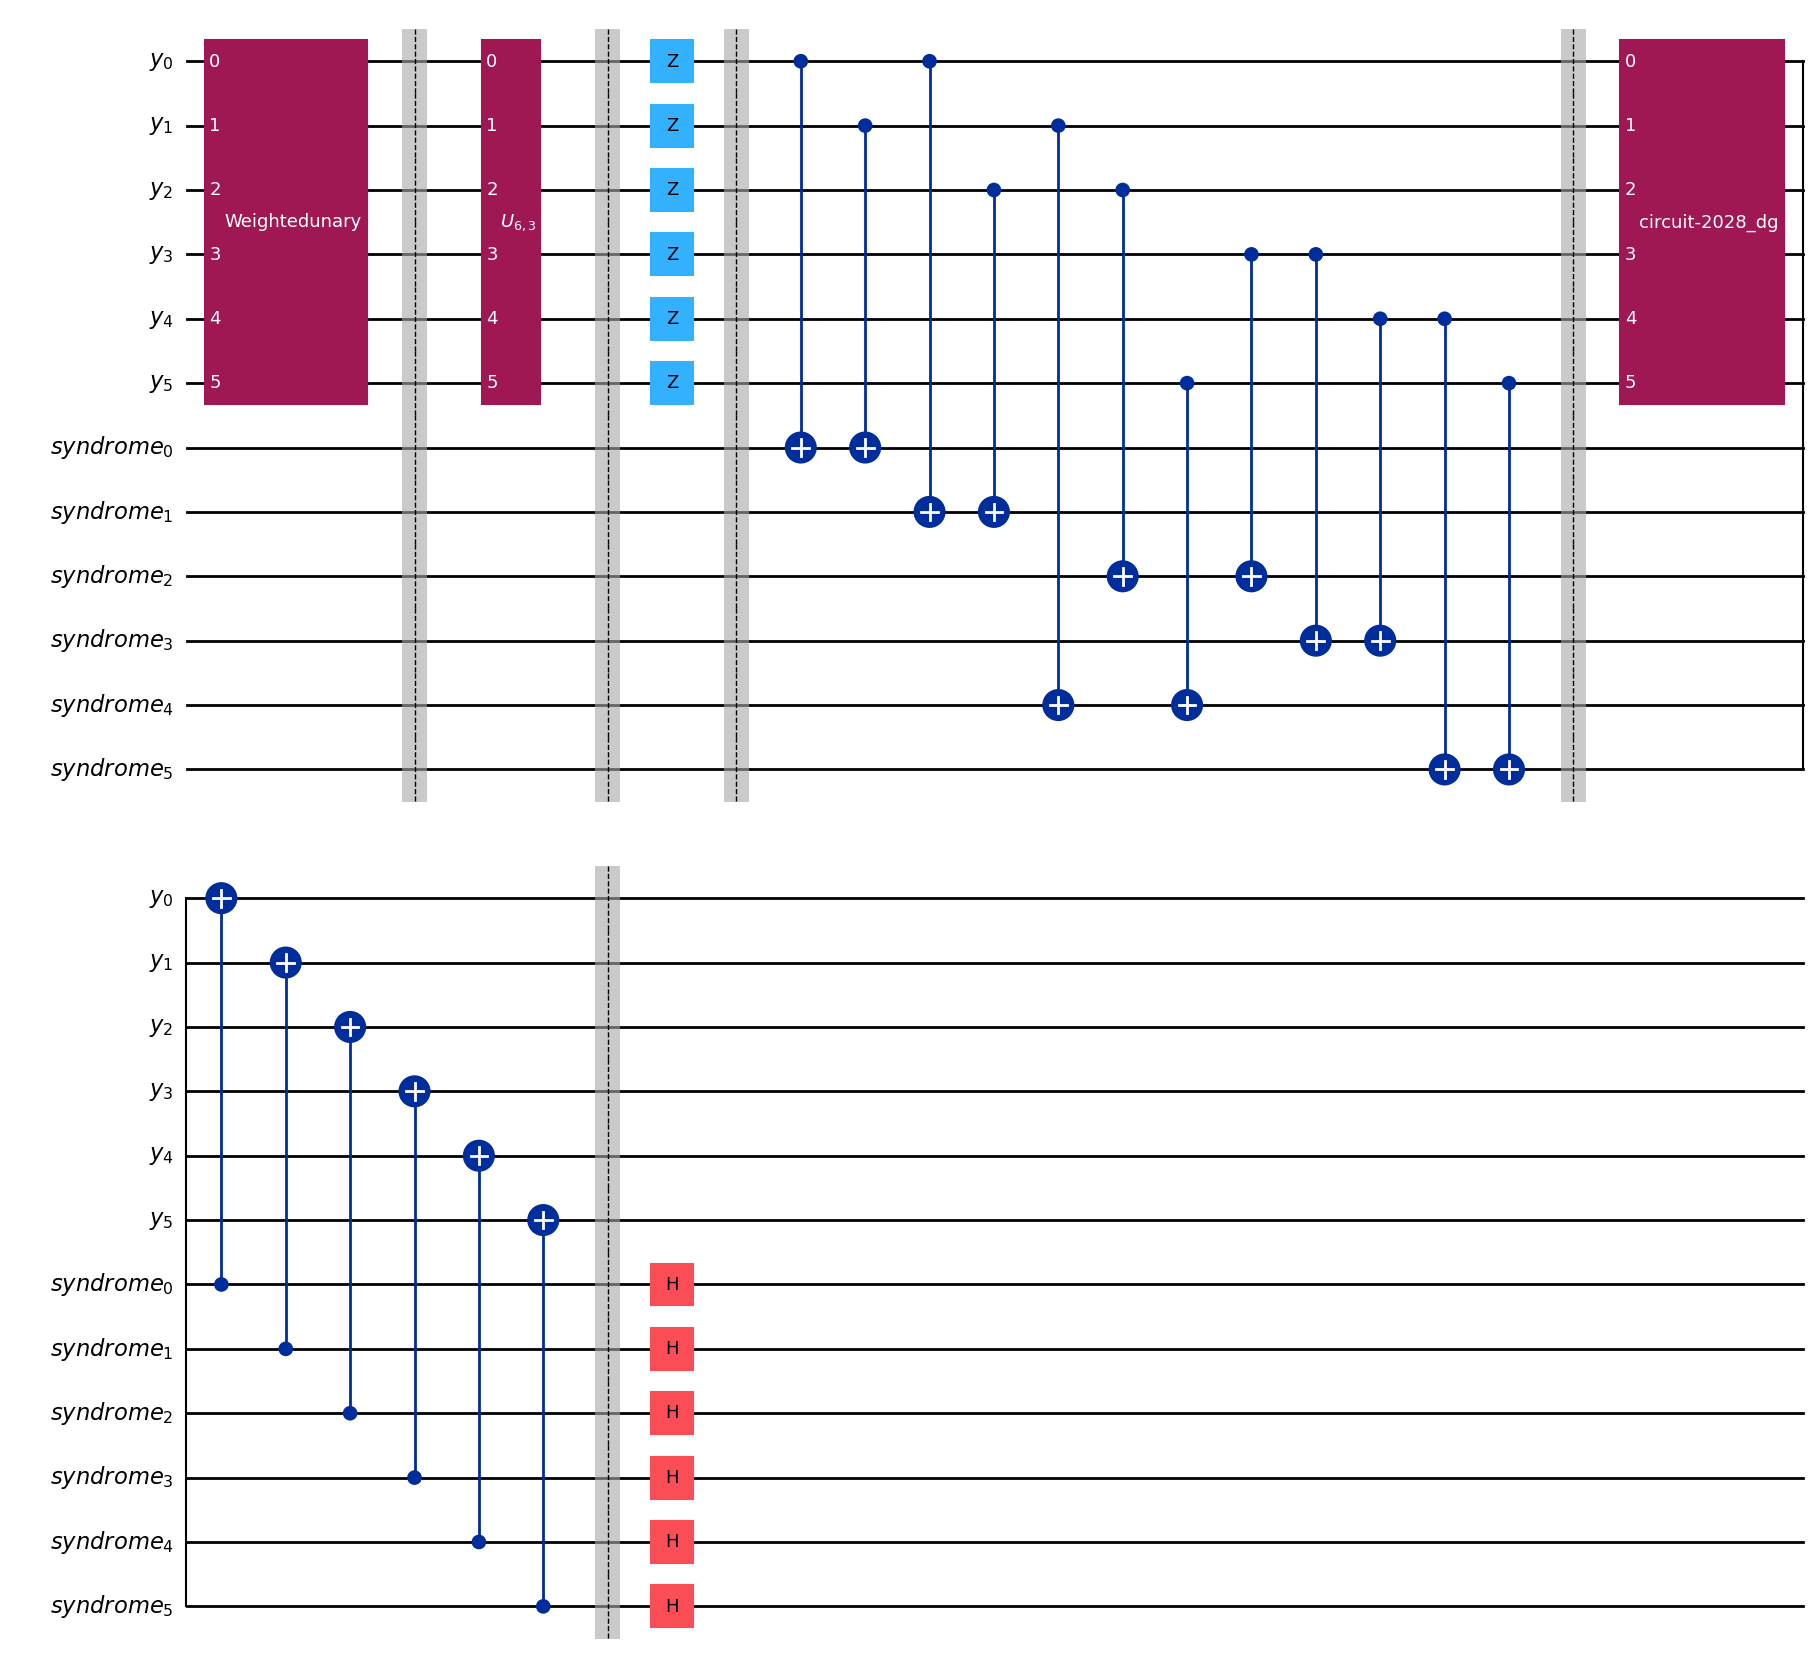

In [367]:
combine_circuit_5 = QuantumCircuit(dicke_qregs, syndrome_qregs)
combine_circuit_5.compose(initialize_circuit, inplace=True)
combine_circuit_5.barrier()
combine_circuit_5.compose(dicke_circuit, inplace=True)
combine_circuit_5.barrier()
combine_circuit_5.compose(v_phase_flip_circuit, qubits=range(m), inplace=True)
combine_circuit_5.barrier()
combine_circuit_5.compose(B_circuit, qubits=list(range(m+n)), inplace=True)
combine_circuit_5.barrier()
combine_circuit_5.append(decoding_circuit.inverse(), range(m))
for i in range(dicke_qregs.size):
    combine_circuit_5.cx(syndrome_qregs[i], dicke_qregs[i])
combine_circuit_5.barrier()
for i in range(syndrome_qregs.size):
    combine_circuit_5.h(dicke_qregs.size+i)
combine_circuit_5.draw('mpl')

In [368]:
from qiskit.quantum_info import partial_trace
reduced_density_matrix = partial_trace(Statevector(combine_circuit_5), range(dicke_qregs.size))

Statevector(np.diagonal(reduced_density_matrix)).draw('latex')


<IPython.core.display.Latex object>

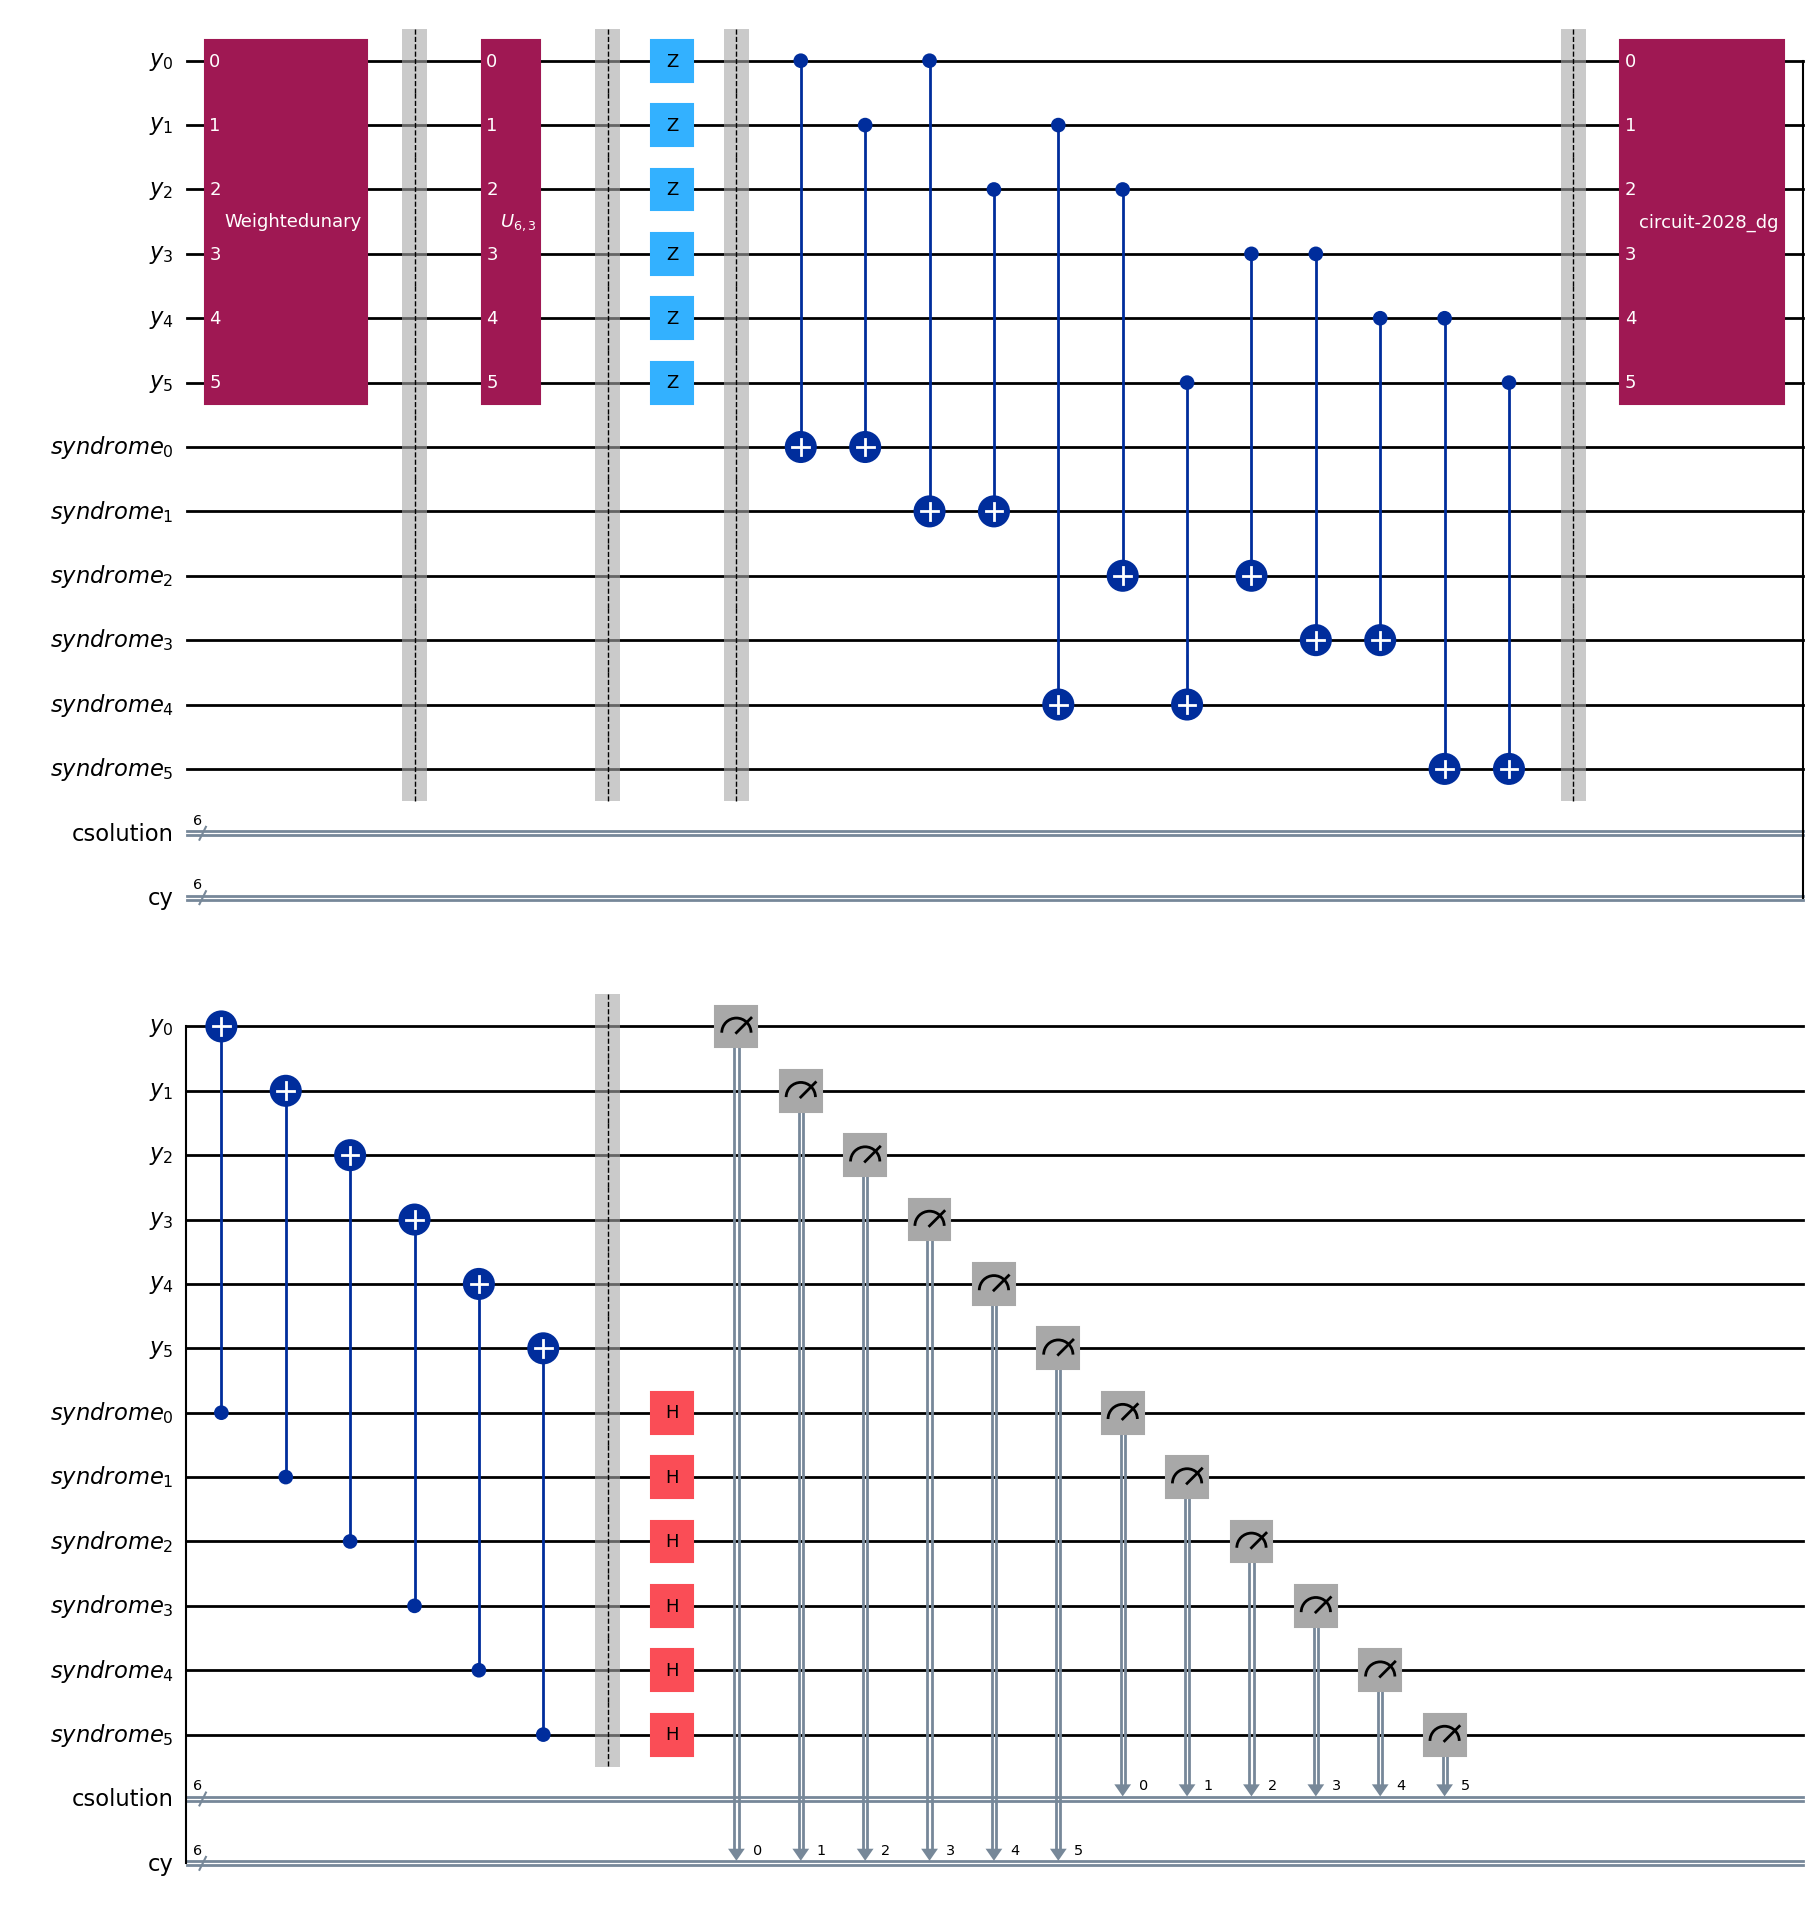

In [369]:
dicke_cregs = ClassicalRegister(dicke_qregs.size, name='cy')
syndrome_cregs = ClassicalRegister(syndrome_qregs.size, name='csolution')

combine_circuit_5 = QuantumCircuit(dicke_qregs, syndrome_qregs, syndrome_cregs, dicke_cregs)
combine_circuit_5.compose(initialize_circuit, inplace=True)
combine_circuit_5.barrier()
combine_circuit_5.compose(dicke_circuit, inplace=True)
combine_circuit_5.barrier()
combine_circuit_5.compose(v_phase_flip_circuit, qubits=range(m), inplace=True)
combine_circuit_5.barrier()
combine_circuit_5.compose(B_circuit, qubits=list(range(m+n)), inplace=True)
combine_circuit_5.barrier()
combine_circuit_5.append(decoding_circuit.inverse(), range(m))
for i in range(dicke_qregs.size):
    combine_circuit_5.cx(syndrome_qregs[i], dicke_qregs[i])
combine_circuit_5.barrier()
for i in range(syndrome_qregs.size):
    combine_circuit_5.h(dicke_qregs.size+i)
combine_circuit_5.measure(dicke_qregs, dicke_cregs)
combine_circuit_5.measure(syndrome_qregs, syndrome_cregs)
combine_circuit_5.draw('mpl')

In [370]:
from qiskit_aer import AerSimulator
from qiskit import transpile

simulator = AerSimulator()
transpiled_circuit = transpile(combine_circuit_5, backend=simulator)
result = simulator.run(transpiled_circuit, shots=10000).result()
counts = result.get_counts(combine_circuit_5)
{k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

{'011110 101001': 204,
 '011110 100010': 203,
 '011110 101110': 191,
 '011110 011010': 188,
 '011110 010110': 185,
 '000000 010110': 183,
 '011110 010001': 177,
 '011110 100101': 177,
 '000000 100010': 173,
 '001010 101110': 172,
 '000000 010001': 171,
 '010100 101001': 169,
 '000000 101001': 168,
 '000000 101110': 166,
 '010100 100010': 164,
 '000000 011101': 163,
 '000000 011010': 162,
 '010100 011010': 160,
 '011110 011101': 157,
 '010100 100101': 157,
 '001010 101001': 156,
 '000000 100101': 155,
 '001010 010001': 153,
 '001010 010110': 148,
 '010100 010110': 146,
 '001010 100010': 146,
 '001010 011101': 143,
 '001010 100101': 143,
 '001010 011010': 141,
 '010100 010001': 136,
 '010100 011101': 136,
 '010100 101110': 111,
 '001010 110010': 66,
 '000100 010110': 64,
 '001010 111001': 63,
 '010000 011010': 61,
 '000100 011101': 60,
 '011010 111001': 59,
 '011010 010001': 57,
 '001010 000110': 56,
 '010000 010001': 56,
 '001010 110101': 55,
 '010000 100101': 54,
 '010100 001110': 54,


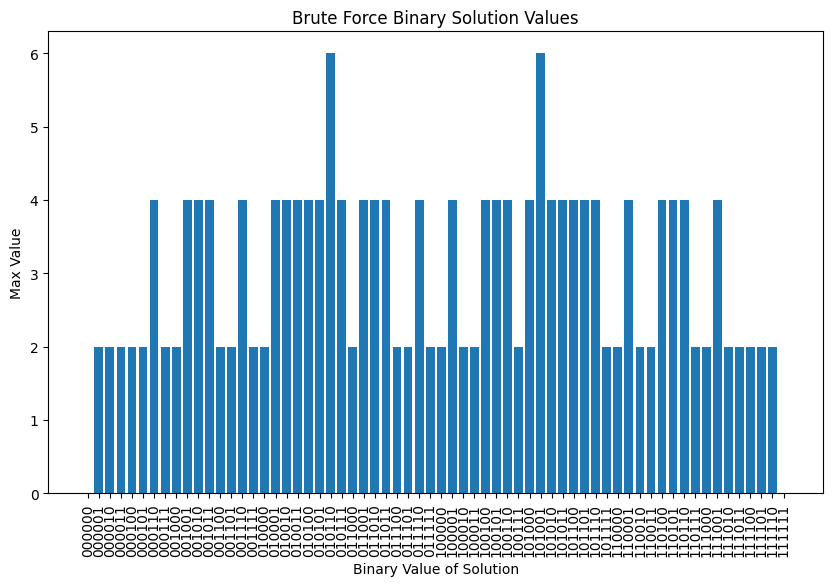

In [371]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

def brute_force_max(B, v):
    num_vars = B.shape[1]  # Number of variables in x
    results = []
    
    # Iterate over all possible binary values of x
    for x_tuple in product([0, 1], repeat=num_vars):
        x = np.array([x_tuple])  # Convert tuple to numpy array
        value = len(B) - sum((B @ x.T + v) % 2)[0]
        binary_value = int(''.join(map(str, x_tuple)), 2)  # Convert binary tuple to integer
        results.append((binary_value, ''.join(map(str, x_tuple)), value))
    
    # Sort by binary value
    results.sort(key=lambda pair: pair[0])
    
    return results

def plot_results(results, top_n=None):
    # If top_n is None, plot all results
    if top_n is None or top_n > len(results):
        top_n = len(results)
    
    # Extract sorted values
    x_labels = [x_str for _, x_str, _ in results[:top_n]]
    y_values = [value for _, _, value in results[:top_n]]
    
    plt.figure(figsize=(10, 6))
    plt.bar(x_labels, y_values)
    plt.xlabel("Binary Value of Solution")
    plt.ylabel("Max Value")
    plt.title("Brute Force Binary Solution Values")
    plt.xticks(rotation=90 if top_n > 20 else 45)
    plt.show()

results = brute_force_max(B, v)
plot_results(results, top_n=None)  # Set to None to plot all results

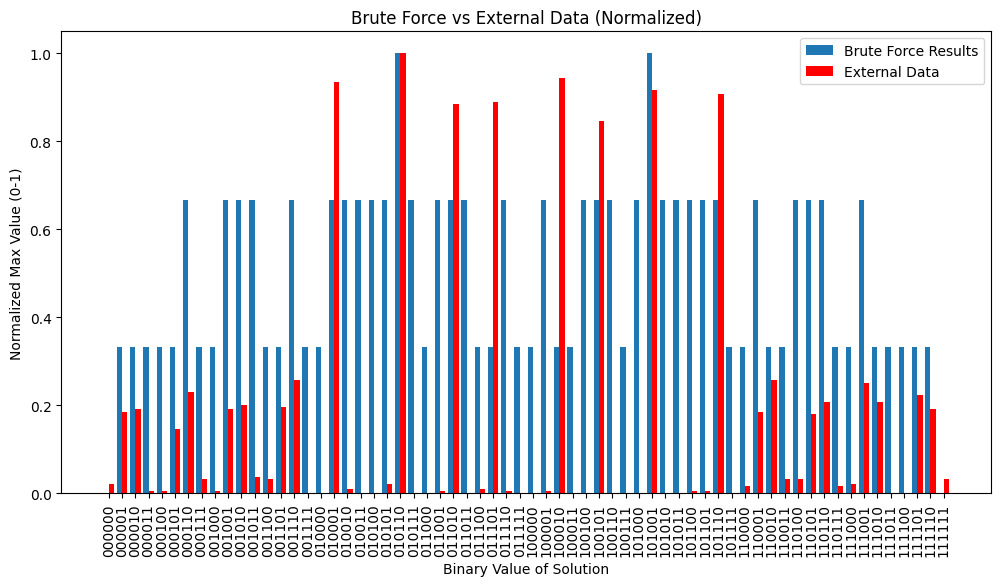

In [372]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

def brute_force_max(B, v):
    num_vars = B.shape[1]  # Number of variables in x
    results = []
    
    # Iterate over all possible binary values of x
    for x_tuple in product([0, 1], repeat=num_vars):
        x = np.array([x_tuple])  # Convert tuple to numpy array
        value = len(B) - sum((B @ x.T + v) % 2)[0]
        binary_value = int(''.join(map(str, x_tuple)), 2)  # Convert binary tuple to integer
        results.append((binary_value, ''.join(map(str, x_tuple)), value))
    
    # Sort by binary value
    results.sort(key=lambda pair: pair[0])
    
    return results

def plot_results(results, external_data=None, top_n=None):
    # If top_n is None, plot all results
    if top_n is None or top_n > len(results):
        top_n = len(results)
    
    # Extract sorted values
    x_labels = [x_str for _, x_str, _ in results[:top_n]]
    y_values = [value for _, _, value in results[:top_n]]
    
    # Normalize y values to range 0-1
    max_y = max(y_values) if y_values else 1
    y_values = [y / max_y for y in y_values]
    
    plt.figure(figsize=(12, 6))
    bar_width = 0.4
    x_pos = np.arange(len(x_labels))
    
    plt.bar(x_pos - bar_width / 2, y_values, width=bar_width, label='Brute Force Results')
    
    # Plot external data if provided
    if external_data:
        ext_x_labels = [k.split(" ")[1] for k in external_data.keys()]
        ext_y_values = list(external_data.values())
        
        # Normalize external y values to range 0-1
        max_ext_y = max(ext_y_values) if ext_y_values else 1
        ext_y_values = [y / max_ext_y for y in ext_y_values]
        
        ext_x_pos = [x_labels.index(x) for x in ext_x_labels if x in x_labels]  # Match positions
        plt.bar([x + bar_width / 2 for x in ext_x_pos], ext_y_values, width=bar_width, label='External Data', color='red')
    
    plt.xlabel("Binary Value of Solution")
    plt.ylabel("Normalized Max Value (0-1)")
    plt.title("Brute Force vs External Data (Normalized)")
    plt.xticks(x_pos, x_labels, rotation=90 if top_n > 20 else 45)
    plt.legend()
    plt.show()

results = brute_force_max(B, v)

# Example external data (replace with actual data)
external_data = {k: v  for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True) if sum([int(v) for v in k.split(" ")[0]]) == 0}

plot_results(results, external_data, top_n=None)  # Set to None to plot all results
